In [46]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False
batch_size=16

In [47]:
import numpy as np

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(n_class * label_true[mask].astype(int) + label_pred[mask],
                        minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc


def add_hist(hist, label_trues, label_preds, n_class):
    """
        stack hist(confusion matrix)
    """

    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)

    return hist

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

In [48]:
%matplotlib inline

dataset_path = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Background"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
category_names = list(sorted_df.Categories)

In [68]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms

    def __getitem__(self, index: int):
        
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)
        
        #segmentation
        cat_ids = self.coco.getCatIds()
        cats = self.coco.loadCats(cat_ids)
        
        masks = np.zeros((image_info["height"], image_info["width"]))
        
        for i in range(len(anns)):
            className = get_classname(anns[i]['category_id'], cats)
            pixel_value = category_names.index(className)
            masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)

        boxes = np.array([x['bbox'] for x in anns])

        # boxex (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
                                
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)
                                
        segmentation = np.array([x['segmentation'] for x in anns], dtype=object)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds, 'masks' : masks}

        # transform
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels,
                'mask' : target['masks']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)
            target['masks'] = sample['mask']
    
        # yolo model format
        # result = []
        # labels_out = torch.zeros((len(labels), 6))
        # for i in range(len(labels)):
        #     result.append(
        #         [labels[i], target['boxes'][i][0], target['boxes'][i][1], target['boxes'][i][2], target['boxes'][i][3]]
        #     )
        # result = np.array(result)

        # if len(labels):
        #     labels_out[:, 1:] = torch.from_numpy(result)

        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [91]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_transform():
    return A.Compose([
#         A.Resize(512, 512),
        A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose([
#         A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [92]:
import matplotlib.patches as patches
annotation = '/opt/ml/input/data/train.json'
data_dir = '/opt/ml/input/data'
train_dataset = CustomDataset(annotation, data_dir, get_train_transform())
# train_dataset = CustomDataset(annotation, data_dir)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.30s)
creating index...
index created!


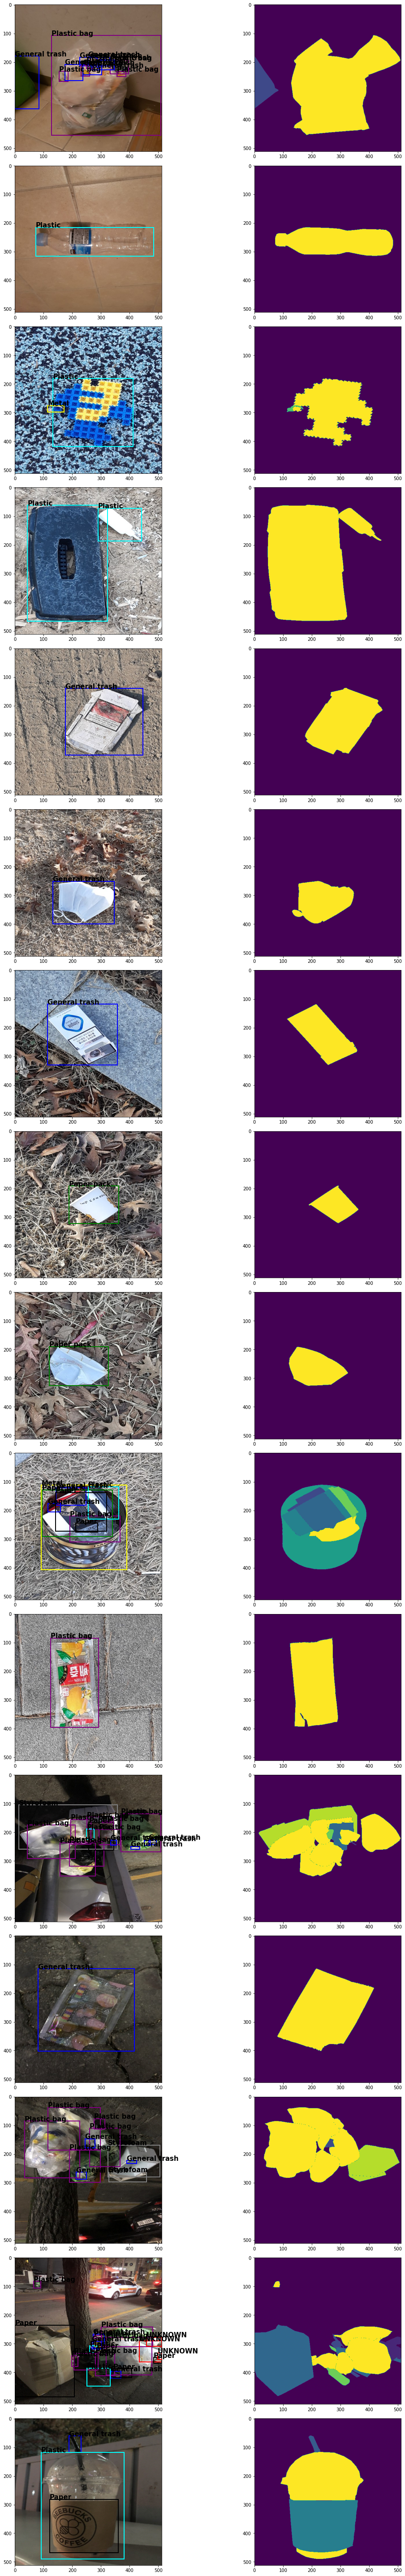

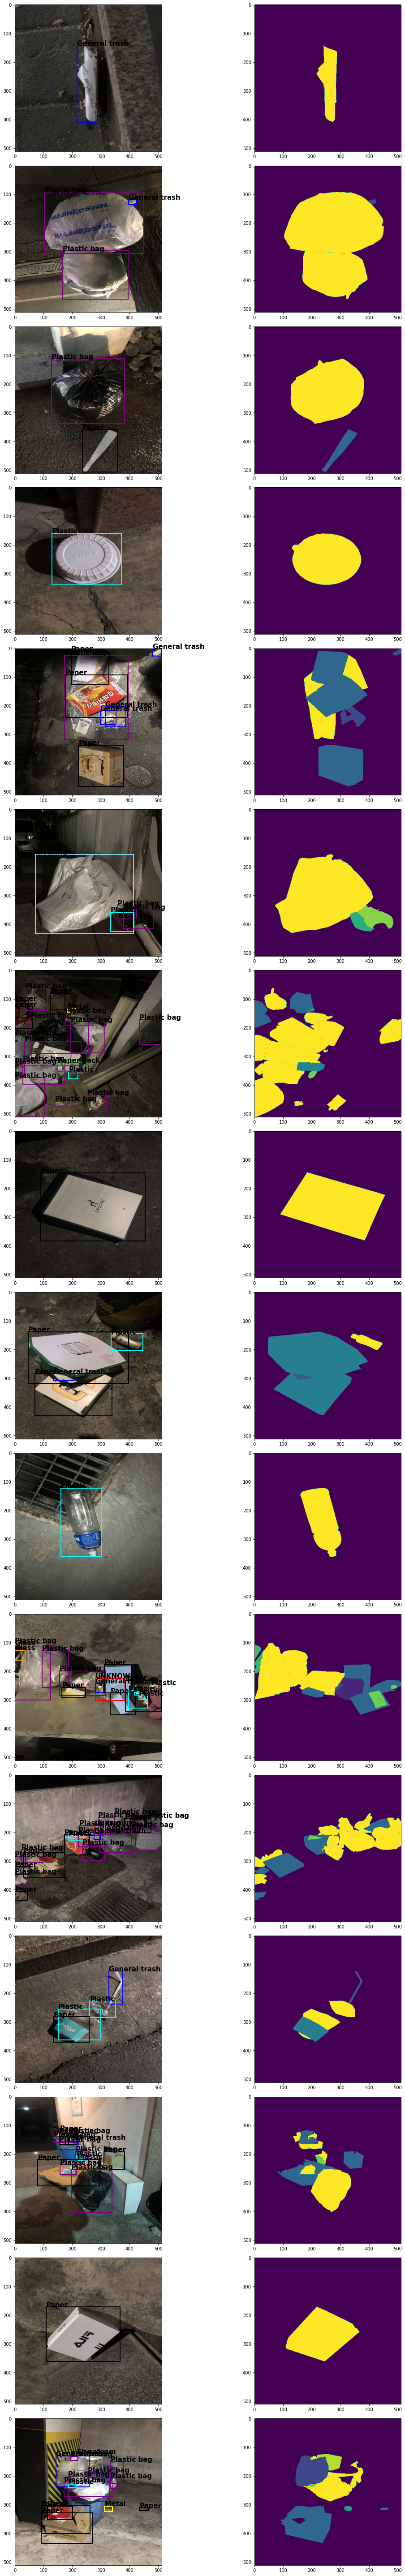

In [95]:
# bounding box 확인하기
color = ['red', 'blue', 'black', 'green', 'yellow', 'orange', 'cyan', 'gray', 'purple', 'tomato', 'skyblue']
classes = ["UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass",
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for idx, (imgs, target, image_id) in enumerate(train_data_loader):
    fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(15, 80))
    plt.tight_layout()
    for i in range(batch_size):
        label = target[i]['labels']
        mask = target[i]['masks']
        x = target[i]['boxes'][:, 0] # xmin
        y = target[i]['boxes'][:, 1] # ymin
        w = target[i]['boxes'][:, 2] # width = xmax - xmin
        h = target[i]['boxes'][:, 3] # height = ymax - ymin
        axes[i,0].imshow(imgs[i].permute([1,2,0]))
        for k in range(len(x)):
            axes[i,0].add_patch(
             patches.Rectangle(
                (x[k], y[k]),
                w[k]-x[k],
                h[k]-y[k],
                edgecolor = color[label[k]],
                facecolor = 'red',
                fill=False,
                linewidth=2
             ))
            axes[i,0].text(x[k], y[k], classes[label[k]], fontsize=15, color='black', weight='bold')
        axes[i,1].imshow(mask)
    plt.show()
#     plt.savefig('EDA_sample.jpg')
    if idx == 1:
        break
